In [5]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import random

import synchrony.PlottingTools as plottingTools
from synchrony.ParameterSet import ParameterSet
import synchrony.DataStorage as dataStorage
import synchrony.DataAnalysis as dataAnalysis
import synchrony.MakeDataframe as makeDataframe
from synchrony import mainClass

In [6]:
file_path_input_params_json = '../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'Paper/Fig_03/Fig_3a' #'Paper/X_Appendix/A4_higher_firing_rate/A4ab' #'Paper/X_Appendix/A4_higher_firing_rate/A4ab' or 'Paper/Fig_4/Fig_4a'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a
parameter_path /home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/parameter_set.csv


# Parameters

In [7]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)


t_max = 10
time_step = 0.0001
rate= 1000

time = np.arange(0, t_max, time_step)

# Make data frame

In [8]:
data_frame = makeDataframe.make_dataframe(file_path)

sorted_dataframe = data_frame.sort_values(by=["hill_activation_potential"], ascending=True)
list_of_hill_coeffs = sorted_dataframe['hill_origin_opening'].unique()

['/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/fraction_synchronized_vary_hill_new_notebook.pdf',
 '/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/8419_n_eff_20_vary_delay',
 '/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/abs_firing_rate.pdf',
 '/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/prob_open.pdf',
 '/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/8421_n_eff_40_vary_delay',
 '/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/8420_n_eff_30_vary_delay',
 '/home/berger/Data/Synchrony/Paper/Fig_03/Fig_3a/8373_hill_10_10_vary_delay_longer']


# General functions

In [5]:
def calcuate_max_rate_given_n_eff(n, growth_rate, v_init, v_b):
    return n*growth_rate * np.log(2)/np.log((2 * v_init**n)/(v_b**n+v_init**n))

def calculate_approx_opening_prob_of_time(t, rate_growth, v_birth, hill_coeff_eff, crit_vol):
    vol= v_birth * np.exp(rate_growth*t)
    return vol**hill_coeff_eff/(vol**hill_coeff_eff+ crit_vol**hill_coeff_eff)

def calculate_whether_initiate(rate, time_step):
    prob = rate * time_step
    random_number = random.random()
    return prob >= random_number

def calculate_fraction_intervals_smaller_than_x(intervalls, x):
    intervalls = np.array(intervalls)
    smaller = intervalls[intervalls<x]
    return smaller.size / intervalls.size

def make_list_intervals(t_max, time_step, rate_growth, v_birth, firing_rate_0, probability):
    n_simu = 1000
    list_t_init_tupel = []
    time = np.arange(0, t_max, time_step)
    for simu_i in range(0, n_simu):
        init_events = []
        for n in range(0,2):
            for n_step in range(1, time.size): # start at one because 0 is the initial condition
                if calculate_whether_initiate(firing_rate_0 * probability[n_step], time_step):
                    init_events.append(time[n_step])
                    break
        list_t_init_tupel.append(init_events)
    delta_t = [abs(item[1]-item[0]) for item in list_t_init_tupel]
    return delta_t

def average_initiation_volume(t_max, time_step, rate_growth, v_birth, firing_rate_0, probability):
    n_simu = 1000
    list_v_init = []
    time = np.arange(0, t_max, time_step)
    volume = v_birth * np.exp(rate_growth * time)
    for simu_i in range(0, n_simu):
        for n_step in range(1, time.size): # start at one because 0 is the initial condition
            if calculate_whether_initiate(firing_rate_0 * probability[n_step], time_step):
                list_v_init.append(volume[n_step])
                break
    return np.mean(np.array(list_v_init)), np.std(np.array(list_v_init))/ np.mean(np.array(list_v_init))

def calculate_fraction_from_prob(prob):
    return prob + (1-prob)* 0.5

# Calculating different probabilities

In [6]:
def calculate_approx_opening_prob_of_time(t, rate_growth, v_birth, hill_coeff_eff, crit_vol):
    vol= v_birth * np.exp(rate_growth*t)
    return vol**hill_coeff_eff/(vol**hill_coeff_eff+ crit_vol**hill_coeff_eff)

def calc_activation_potential(v_init, hill, volume):
    return 1/(1 + (v_init / volume)** hill)

def calc_opening_prob(f_crit, hill, activation_potential):
    return 1/(1+(f_crit / activation_potential)**hill)

from scipy.optimize import curve_fit

def fitting_hill_funct(v, alpha, k, v_tilde):
    return alpha /(1+(v_tilde/v)**k)

def generate_fitting_params(row):
    volume = np.arange(0.1, 2, time_step)
    activation_potential = calc_activation_potential(row.v_init_th, row.hill_activation_potential, volume)
    origin_opening_prob = calc_opening_prob(row.f_crit, row.hill_origin_opening, activation_potential)
    popt, pcov = curve_fit(fitting_hill_funct, volume, origin_opening_prob)
#     print(row.hill_origin_opening, popt)
    return popt

data_frame.loc[:, 'fitting_params'] = data_frame.apply(lambda row: generate_fitting_params(row), axis = 1) 

# Simulations for approximation, double function and fitted function

In [7]:
cache_delta_t_approx = {}
cache_delta_t_f2 = {}
cache_delta_t_fitted = {}

for item in range(0,list_of_hill_coeffs.size):
    data_frame_item = data_frame.loc[data_frame['hill_origin_opening']==list_of_hill_coeffs[item]]
    print(data_frame_item['hill_activation_potential'].iloc[0])
    volume = data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0] * np.exp(time * data_frame_item['rate_growth'].iloc[0])
    
    # approximation
    approx_open_prob = calculate_approx_opening_prob_of_time(time, 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['n_eff'].iloc[0],
                                  data_frame_item['v_init_th'].iloc[0])
    delta_t_approx = make_list_intervals(t_max, 
                                  time_step, #data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['origin_open_and_firing_rate'].iloc[0], #rate[item], #data_frame_item['origin_firing_rate'].iloc[0],
                                  approx_open_prob
                                 )
    cache_delta_t_approx[list_of_hill_coeffs[item]]= delta_t_approx
    
    # double function
    activation_potential = calc_activation_potential(data_frame_item['v_init_th'].iloc[0], 
                                                     data_frame_item['hill_activation_potential'].iloc[0], 
                                                     volume)
    origin_opening_prob = calc_opening_prob(data_frame_item['f_crit'].iloc[0], 
                                            data_frame_item['hill_origin_opening'].iloc[0], 
                                            activation_potential)
    delta_t_f2 = make_list_intervals(t_max, 
                                  time_step, #data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['origin_open_and_firing_rate'].iloc[0], #rate[item], #data_frame_item['origin_firing_rate'].iloc[0],
                                  origin_opening_prob
                                 )
    cache_delta_t_f2[list_of_hill_coeffs[item]]= delta_t_f2
    
    # fitted function
    fitting_params = data_frame_item['fitting_params'].iloc[0]
    fitted_opening_prob = fitting_hill_funct(volume, fitting_params[0], fitting_params[1], fitting_params[2])
    delta_t_fitted = make_list_intervals(t_max, 
                                  time_step, #data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['origin_open_and_firing_rate'].iloc[0], #rate[item], #data_frame_item['origin_firing_rate'].iloc[0],
                                  fitted_opening_prob
                                 )
    cache_delta_t_fitted[list_of_hill_coeffs[item]]= delta_t_fitted
    
    
    
data_frame.loc[:, 'simu_approx_prob'] = data_frame.apply(lambda row: calculate_fraction_intervals_smaller_than_x(cache_delta_t_approx[row.hill_origin_opening], row.t_doubling_datA), axis = 1) 
data_frame.loc[:, 'simu_approx_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob(row.simu_approx_prob), axis = 1)
    
data_frame.loc[:, 'simu_double_f_prob'] = data_frame.apply(lambda row: calculate_fraction_intervals_smaller_than_x(cache_delta_t_f2[row.hill_origin_opening], row.t_doubling_datA), axis = 1) 
data_frame.loc[:, 'simu_double_f_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob(row.simu_double_f_prob), axis = 1)

data_frame.loc[:, 'simu_fitted_prob'] = data_frame.apply(lambda row: calculate_fraction_intervals_smaller_than_x(cache_delta_t_fitted[row.hill_origin_opening], row.t_doubling_datA), axis = 1) 
data_frame.loc[:, 'simu_fitted_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob(row.simu_fitted_prob), axis = 1)


6.3245553203
7.7459666924
8.94427191
10.0


# Calculate average initiation volume and CV from cell cycle

In [8]:
def obtain_v_init_mean(filepath_h5):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_init_events')
    v_init = np.array(data_frame_traces['v_init'])
    return np.mean(v_init)

def obtain_CV(filepath_h5):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_init_events')
    v_init = np.array(data_frame_traces['v_init'])
    return np.std(v_init) / np.mean(v_init)

data_frame.loc[:, 'v_init_mean_cell_cycle'] = data_frame.apply(lambda row: obtain_v_init_mean(row.path_dataset), axis = 1)

data_frame.loc[:, 'CV_cell_cycle'] = data_frame.apply(lambda row: obtain_CV(row.path_dataset), axis = 1)


In [9]:
data_frame['CV_cell_cycle']

0     0.344639
1     0.310280
2     0.380692
3     0.265131
4     0.370526
        ...   
71    0.048643
72    0.206062
73    0.319922
74    0.156085
75    0.060135
Name: CV_cell_cycle, Length: 76, dtype: float64

# Cell cycle simulation degree of synchrony

In [10]:
def fraction_initiated_origins_per_cascade(initiation_times, n_ori_init, row):
    cascade_event_list = []
    new_cluster = 1
    n_ori = 1
    n_steps_extra = 0 # time added to delay time for maximal duration of one cascade
    for indx in range(0, initiation_times.size):
#         print(indx)
        if new_cluster == 1:
            count = 1
            t_max = initiation_times[indx] + row.t_doubling_datA + n_steps_extra * row.time_step
            n_ori = n_ori_init[indx]
            new_cluster = 0
        else:
            if initiation_times[indx] <= t_max:
                count = count + 1
            else:
#                 if row.site_datA == 0.24:
#                     print('fraction of origins initiated:', count, n_ori, count/ n_ori)
                cascade_event_list.append(count/ n_ori)
                count = 1
                t_max = initiation_times[indx] +  row.t_doubling_datA + n_steps_extra * row.time_step
                n_ori = n_ori_init[indx]
#     print(row.sub_simu_name, cascade_event_list)   
#     print('init times:', np.array(initiation_times))
    return cascade_event_list

def mean_and_var_of_fraction_initiated_origins_per_cascade(row):
    data_frame_init = pd.read_hdf(row.path_dataset, key='dataset_init_events')
    initiation_times = data_frame_init['t_init']
    n_ori_init = data_frame_init['n_ori_init']
    fract_init_origins_per_cascade = fraction_initiated_origins_per_cascade(initiation_times, n_ori_init,  row)
    return np.mean(fract_init_origins_per_cascade), np.var(fract_init_origins_per_cascade)

def degree_synch(row):
    degree_synch, variance_synch = mean_and_var_of_fraction_initiated_origins_per_cascade(row)
    return degree_synch

def variance_synch(row):
    degree_synch, variance_synch = mean_and_var_of_fraction_initiated_origins_per_cascade(row)
    return variance_synch


data_frame.loc[:, 'degree_synch'] = data_frame.apply(lambda row: degree_synch(row), axis = 1)
data_frame.loc[:, 'variance_synch'] = data_frame.apply(lambda row: variance_synch(row), axis = 1)

# Theoretical degree of synchrony

In [11]:
def integrand_prob_two_events_new(t1, growth_rate_, v_init_, V_b_, n_, firing_rate_0_, delta_t):
    vol_t1 = V_b_ * np.exp(growth_rate_ * t1)
    vol_t1_delay = V_b_ * np.exp(growth_rate_ * (t1+ delta_t))
    prefactor = 2 * firing_rate_0_ * vol_t1**n_/(vol_t1**n_ + v_init_**n_)
    exponential = ((vol_t1_delay**n_ + v_init_**n_) * (vol_t1**n_ + v_init_**n_)/(V_b_**n_ + v_init_**n_)**2)**(-firing_rate_0_/(growth_rate_ * n_))
    return prefactor * exponential

In [12]:
data_frame.loc[:, 'theoretical_prediction'] = data_frame.apply(lambda row: 1-integrate.quad(lambda x: integrand_prob_two_events_new(x,
                                                                                               row.rate_growth,
                                                                                               row.v_init_th,
                                                                                               0.01,
                                                                                               row.hill_activation_potential * row.hill_origin_opening /2, 
                                                                                               row.origin_firing_rate,
                                                                                               row.t_doubling_datA) , 0,  13)[0], axis = 1)
data_frame.loc[:, 'th_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob(row.theoretical_prediction), axis = 1)


/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


# Legends

In [13]:
def make_hill_coeff_legend(hill_activation_potential, hill_origin_opening):
    return r'$n_{{\rm eff}}={}$'.format(int(np.round(hill_activation_potential*hill_origin_opening/2,0)))

def make_deactivation_rate_legend(deactivation_rate_datA):
    return r'$\beta_{{datA}}={}$ min$^{{-1}}$'.format(int(deactivation_rate_datA/60))

def make_mich_menten_legend(michaelis_const_deact):
    return r'$K_{{D}}={} \, \mu$m$^{{-3}}$'.format(int(michaelis_const_deact))
    
data_frame.loc[:, 'Hill coefficients:'] = data_frame.apply(lambda row: make_hill_coeff_legend(row.hill_activation_potential, row.hill_origin_opening), axis = 1)
  
data_frame.loc[:, 'deactivation rate:'] = data_frame.apply(lambda row: make_deactivation_rate_legend(row.deactivation_rate_datA), axis = 1)

data_frame.loc[:, 'Dissociation constant:'] = data_frame.apply(lambda row: make_mich_menten_legend(row.michaelis_const_deact), axis = 1)

# Plot degree of synchrony

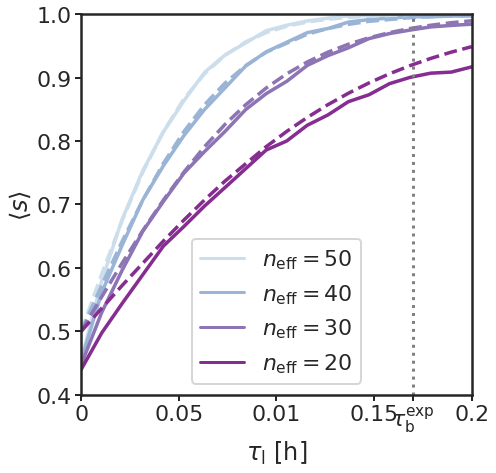

In [17]:
from matplotlib import cm
sns.set(style="ticks")
sns.set_context("poster")
palette='BuPu'

ylorbr = cm.get_cmap('BuPu', 100)
x = ylorbr(np.linspace(0,1,10))

data_frame_sorted = data_frame.sort_values(by=["hill_activation_potential"], ascending=True)
fig, ax = plt.subplots(figsize=(7,7))
ax.set(xlabel=r'$\tau_{\rm l}$ [h]', ylabel=r'$\langle s \rangle$')
sns.lineplot(
    x='t_doubling_datA', 
    y='degree_synch',
    data=data_frame_sorted.sort_values(by=["hill_activation_potential"], ascending=False),
    hue='Hill coefficients:',
#     hue='deactivation rate:',
#     dashes=[(4, 1), ''],
#     markers=True,
#     linestyle="dotted",
    palette= palette,
#     style='theoretical_prediction',
    linewidth = 3.5,
    ax=ax
);

sns.lineplot(
    x='t_doubling_datA', 
    y='th_deg_synch',
    data=data_frame_sorted.sort_values(by=["hill_activation_potential"], ascending=False),
    hue='Hill coefficients:',
#     hue='deactivation rate:',
    linestyle="dashed",
    markers=True,
    palette= palette,
#     style='theoretical_prediction',
    linewidth = 3.5,
    legend = False,
    ax=ax
);

# sns.lineplot(
#     x='t_doubling_datA', 
#     y='simu_double_f_deg_synch',
#     data=data_frame_sorted.sort_values(by=["hill_activation_potential"], ascending=False),
#     hue='Hill coefficients:',
# #     hue='deactivation rate:',
#     linestyle="dotted",
#     markers=True,
#     palette= palette,
# #     style='theoretical_prediction',
#     linewidth = 3.5,
#     legend = False,
#     ax=ax
# );

# sns.lineplot(
#     x='t_doubling_datA', 
#     y='simu_approx_deg_synch',
#     data=data_frame_sorted.sort_values(by=["hill_activation_potential"], ascending=False),
#     hue='Hill coefficients:',
# #     hue='deactivation rate:',
#     linestyle="--",
#     markers=True,
#     palette= palette,
# #     style='theoretical_prediction',
#     linewidth = 3.5,
#     legend = False,
#     ax=ax
# );
ax.margins(0)

# ax.axhline(y=0.96+(1-0.96)*0.5, color='grey', linestyle='dotted')
# ax.axhline(y=0.99+(1-0.99)*0.5, color='grey', linestyle='dotted')
# ax.axhline(y=0.5, color=green, linestyle='--')
ax.axvline(x=0.17, color='grey', linestyle='dotted')
# ax.axvline(x=0.16, color=x[5], linestyle='dotted')
# ax.axvline(x=0.09, color=x[4], linestyle='dotted')
# ax.axvline(x=0.06, color=x[2], linestyle='dotted')
ax.set(ylim=(0.4, 1))
ax.set_xticks([0,0.05, 0.1, 0.15, 0.17, 0.2])
ax.set_xticklabels([r'0',r'0.05', r'0.01', r'0.15', r'$\tau_{\rm b}^{\rm exp}$', r'0.2'])
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
# ax.legend(bbox_to_anchor=(1, 1))
plt.savefig(file_path + '/fraction_synchronized_vary_hill_new_notebook.pdf', format='pdf', bbox_inches='tight')

In [18]:
df_40_exp = data_frame[(data_frame['n_eff'] == 20.0) & (data_frame['t_onset_datA'] == 0.1684210526)]

print(df_40_exp["theoretical_prediction"])

6    0.837963
Name: theoretical_prediction, dtype: float64


# Plot Probabilities

## obtain average initiation volumne

In [19]:
list_v_init_av_double = []
list_v_init_av_approx = []
list_v_init_av_fit = []
list_CV_av_double = []
list_CV_av_approx = []
list_CV_av_fit = []
for item in range(0,list_of_hill_coeffs.size):
    data_frame_item = data_frame.loc[data_frame['hill_origin_opening']==list_of_hill_coeffs[item]]
    # calculate probabilities
    # approx
    approx_open_prob = calculate_approx_opening_prob_of_time(time, 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['n_eff'].iloc[0],
                                  data_frame_item['v_init_th'].iloc[0])
    # double function
    volume = data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0] * np.exp(time * data_frame_item['rate_growth'].iloc[0])
    activation_potential = calc_activation_potential(data_frame_item['v_init_th'].iloc[0], 
                                                     data_frame_item['hill_activation_potential'].iloc[0], 
                                                     volume)
    print(data_frame_item['hill_activation_potential'].iloc[0])
    origin_opening_prob = calc_opening_prob(data_frame_item['f_crit'].iloc[0], 
                                            data_frame_item['hill_origin_opening'].iloc[0], 
                                            activation_potential)
    # fitted 
    fitting_params = data_frame_item['fitting_params'].iloc[0]
    fitted_opening_prob = fitting_hill_funct(volume, fitting_params[0], fitting_params[1], fitting_params[2])
    
    v_init_av_double, CV_av_double = average_initiation_volume(t_max, 
                                  time_step, #data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['origin_open_and_firing_rate'].iloc[0], #rate[item], #data_frame_item['origin_firing_rate'].iloc[0],
                                  origin_opening_prob
                                 )
    v_init_av_approx, CV_av_approx = average_initiation_volume(t_max, 
                                  time_step, #data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['origin_open_and_firing_rate'].iloc[0], #rate[item], #data_frame_item['origin_firing_rate'].iloc[0],
                                  approx_open_prob
                                 )
    v_init_av_fit, CV_av_fit = average_initiation_volume(t_max, 
                                  time_step, #data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0],
                                  data_frame_item['origin_open_and_firing_rate'].iloc[0], #rate[item], #data_frame_item['origin_firing_rate'].iloc[0],
                                  fitted_opening_prob
                                 )
    list_v_init_av_double.append(v_init_av_double)
    list_v_init_av_approx.append(v_init_av_approx)
    list_v_init_av_fit.append(v_init_av_fit)
    
    list_CV_av_double.append(CV_av_double)
    list_CV_av_approx.append(CV_av_approx)
    list_CV_av_fit.append(CV_av_fit)
    

6.3245553203
7.7459666924
8.94427191
10.0


## plot probability as a function of volume

hill 6.3245553203
rate 51.98604077517424
6.3245553203
[ 0.97826536 20.05983009  1.00190236]
hill 7.7459666924
rate 20.8237392889151
7.7459666924
[ 0.9904102  29.66968611  1.00188325]
hill 8.94427191
rate 31.192996454525485
8.94427191
[ 0.99496455 39.46246084  1.00147034]
hill 10.0
rate 41.58888805251046
10.0
[ 0.99701514 49.3456611   1.00114102]


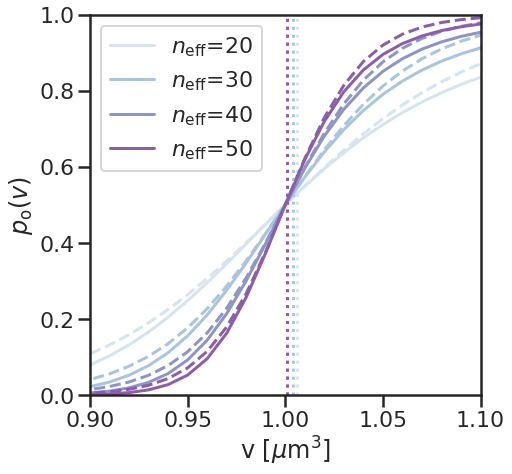

In [20]:
import matplotlib as matplotlib
sns.set(style="ticks")
sns.set_context("poster")
pallette = 'BuPu'
color_list = sns.color_palette(pallette, 5)

fig, ax = plt.subplots(figsize=(7,7))

counter = 0
for item in list_of_hill_coeffs:
    print('hill', item)
    print('rate', calcuate_max_rate_given_n_eff(data_frame_item['n_eff'].iloc[0],
                                                                data_frame_item['rate_growth'].iloc[0], 
                                                                data_frame_item['v_init_th'].iloc[0], 
                                                                data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0]))
    data_frame_item_1 = data_frame.loc[data_frame['hill_origin_opening']==item]
    data_frame_item = data_frame_item_1.loc[data_frame_item_1['t_doubling_datA']==0.2]
    print(data_frame_item.hill_origin_opening.iloc[0])
    volume = np.arange(0.01, 2, 0.01)
    activation_potential = calc_activation_potential(data_frame_item.v_init_th.iloc[0], data_frame_item.hill_activation_potential.iloc[0], volume)
    origin_opening_prob = calc_opening_prob(data_frame_item.f_crit.iloc[0], data_frame_item.hill_origin_opening.iloc[0], activation_potential)
    opening_pro_neff = fitting_hill_funct(volume, 1, data_frame_item.hill_origin_opening.iloc[0] * data_frame_item.hill_origin_opening.iloc[0]/2, data_frame_item.v_init_th.iloc[0])
    
    
    plt.plot(volume,origin_opening_prob, label=r'$n_{\rm eff}$='+str(int(np.round(item*item/2, 0))), color= color_list[counter])
    popt =  data_frame_item["fitting_params"].iloc[0]
    print(popt)
#     plt.plot(volume, 
#              fitting_hill_funct(volume, *popt), 
#              linestyle = '--', color= color_list[counter])
    plt.plot(volume,opening_pro_neff, linestyle = 'dashed', color= color_list[counter])
    
    ax.axvline(x=list_v_init_av_approx[counter], color=color_list[counter], linestyle='dotted')
    
    counter = counter + 1


ax.set(ylim=(0,1))
ax.set(xlim=(0.9,1.1))
plt.legend()
ax.margins(0)
ax.set(xlabel=r'v [$\mu$m$^3$]', ylabel=r'$p_{\rm o}(v)$')
plt.savefig(file_path + '/prob_open.pdf', format='pdf', bbox_inches='tight')

## Plot absolute firing rate

hill 6.3245553203
rate 51.98604077517424
6.3245553203
[ 0.97826536 20.05983009  1.00190236]
hill 7.7459666924
rate 20.8237392889151
7.7459666924
[ 0.9904102  29.66968611  1.00188325]
hill 8.94427191
rate 31.192996454525485
8.94427191
[ 0.99496455 39.46246084  1.00147034]
hill 10.0
rate 41.58888805251046
10.0
[ 0.99701514 49.3456611   1.00114102]


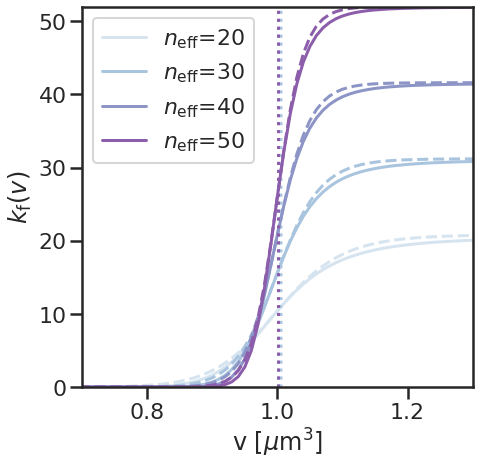

In [21]:
import matplotlib as matplotlib
sns.set(style="ticks")
sns.set_context("poster")
pallette = 'BuPu'
color_list = sns.color_palette(pallette, 5)

fig, ax = plt.subplots(figsize=(7,7))

counter = 0
for item in list_of_hill_coeffs:
    print('hill', item)
    print('rate', calcuate_max_rate_given_n_eff(data_frame_item['n_eff'].iloc[0],
                                                                data_frame_item['rate_growth'].iloc[0], 
                                                                data_frame_item['v_init_th'].iloc[0], 
                                                                data_frame_item['v_birth_th'].iloc[0]/ data_frame_item['n_ori_birth'].iloc[0]))
    data_frame_item_1 = data_frame.loc[data_frame['hill_origin_opening']==item]
    data_frame_item = data_frame_item_1.loc[data_frame_item_1['t_doubling_datA']==0.2]
    print(data_frame_item.hill_origin_opening.iloc[0])
    volume = np.arange(0.01, 2, 0.01)
    activation_potential = calc_activation_potential(data_frame_item.v_init_th.iloc[0], data_frame_item.hill_activation_potential.iloc[0], volume)
    origin_opening_prob = calc_opening_prob(data_frame_item.f_crit.iloc[0], data_frame_item.hill_origin_opening.iloc[0], activation_potential)
    opening_pro_neff = fitting_hill_funct(volume, 1, data_frame_item.hill_origin_opening.iloc[0] * data_frame_item.hill_origin_opening.iloc[0]/2, data_frame_item.v_init_th.iloc[0])
    
    
    plt.plot(volume,origin_opening_prob * data_frame_item['origin_firing_rate'].iloc[0], label=r'$n_{\rm eff}$='+str(int(np.round(item*item/2, 0))), color= color_list[counter])
    popt =  data_frame_item["fitting_params"].iloc[0]
    print(popt)
#     plt.plot(volume, 
#              fitting_hill_funct(volume, *popt)* data_frame_item['origin_firing_rate'].iloc[0], 
#              linestyle = '--', color= color_list[counter])
    plt.plot(volume,opening_pro_neff* data_frame_item['origin_firing_rate'].iloc[0], linestyle = 'dashed', color= color_list[counter])
    
    ax.axvline(x=list_v_init_av_approx[counter], color=color_list[counter], linestyle='dotted')
    
    counter = counter + 1


# ax.set(ylim=(0,1))
ax.set(xlim=(0.7,1.3))
plt.legend()
ax.margins(0)
ax.set(xlabel=r'v [$\mu$m$^3$]', ylabel=r'$k_{\rm f}(v)$')
plt.savefig(file_path + '/abs_firing_rate.pdf', format='pdf', bbox_inches='tight')